In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Ustawienia wyświetlania wykresów
%matplotlib inline

# Pobranie danych od 01-01-2019 do 31-12-2022
df = yf.download('ETH-USD', start='2019-01-01', end='2021-12-31')

# Użyjemy tylko kolumny 'Close' jako cechy
data = df[['Close']].values

# Skalowanie danych do zakresu (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Definiowanie funkcji do tworzenia sekwencji danych
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Tworzenie sekwencji z look_back = 60 dni
look_back = 60
X, Y = create_dataset(scaled_data, look_back)

# Reshape danych wejściowych do formatu [próbki, timesteps, cechy]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Podział na zbiór treningowy i testowy (80% treningowy, 20% walidacyjny)
train_size = int(len(X) * 0.7)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

# Budowa modelu LSTM
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dense(25))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

# Trenowanie modelu z walidacją
history = model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_data=(X_val, Y_val), verbose=1)

# Predykcja na zbiorze walidacyjnym
predicted_val = model.predict(X_val)
predicted_val = scaler.inverse_transform(predicted_val)
Y_val_inverse = scaler.inverse_transform(Y_val.reshape(-1, 1))

# Pobranie dat dla zbioru walidacyjnego
validation_dates = df.index[look_back + train_size:]

# Wykres porównujący na zbiorze walidacyjnym
plt.figure(figsize=(14,5))
plt.plot(validation_dates, Y_val_inverse, color='black', label='Rzeczywiste ceny AAPL (walidacja)')
plt.plot(validation_dates, predicted_val, color='green', label='Przewidywane ceny AAPL (walidacja)')
plt.title('Porównanie przewidywanych i rzeczywistych cen akcji AAPL na zbiorze walidacyjnym')
plt.xlabel('Data')
plt.ylabel('Cena akcji')
plt.legend()
plt.show()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


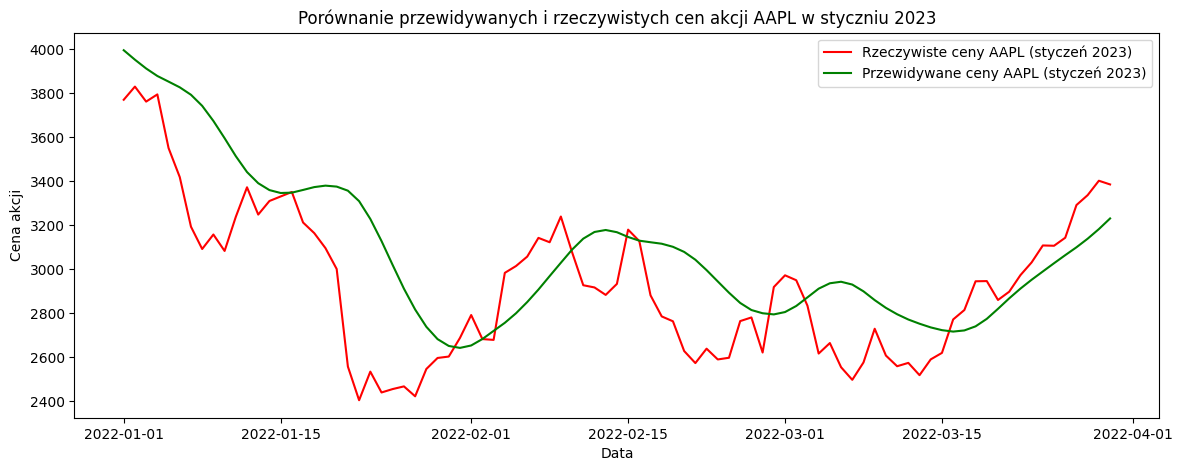

In [6]:
# Pobranie danych do 31-12-2022 dla predykcji na styczeń 2023
train_data = yf.download('ETH-USD', start='2017-01-01', end='2021-12-31')
train_close = train_data[['Close']].values

# Pobranie danych od 01-01-2023 do 31-01-2023 (bez patrzenia na nie)
test_data = yf.download('ETH-USD', start='2022-01-01', end='2022-03-31')
actual_prices = test_data[['Close']].values

# Łączenie danych w celu zachowania ciągłości sekwencji
total_dataset = np.concatenate((train_close, actual_prices), axis=0)

# Przygotowanie danych do predykcji
inputs = total_dataset[len(total_dataset) - len(actual_prices) - look_back:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predykcja cen na styczeń 2023
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Rzeczywiste ceny zamknięcia dla stycznia 2023
real_prices = test_data['Close'].values

# Daty dla stycznia 2023
test_dates = test_data.index

# Wykres porównujący dla stycznia 2023
plt.figure(figsize=(14,5))
plt.plot(test_dates, real_prices, color='red', label='Rzeczywiste ceny AAPL (styczeń 2023)')
plt.plot(test_dates, predicted_prices, color='green', label='Przewidywane ceny AAPL (styczeń 2023)')
plt.title('Porównanie przewidywanych i rzeczywistych cen akcji AAPL w styczniu 2023')
plt.xlabel('Data')
plt.ylabel('Cena akcji')
plt.legend()
plt.show()
